## ML HW2 sample code

若有問題可直接寄信至助教信箱，環境部分推薦使用前述所提到之環境，若使用自己的電腦執行，請注意環境的相容性


In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:18
🔁 Restarting kernel...


In [1]:
!conda env create -f ml_hw3.yml

WARNING conda.models.version:get_matcher(546): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.8.0.*, but conda is ignoring the .* and treating it as 1.8.0
WARNING conda.models.version:get_matcher(546): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.6.0.*, but conda is ignoring the .* and treating it as 1.6.0
WARNING conda.models.version:get_matcher(546): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.9.0.*, but conda is ignoring the .* and treating it as 1.9.0
| / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - 

In [2]:
!conda activate ml_hw3


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.




In [3]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c ml2023-fall-hw2
!unzip 'ml2023-fall-hw2.zip'

串流輸出內容已截斷至最後 5000 行。
  inflating: 2023HW2_7000/train/33887.jpg  
  inflating: 2023HW2_7000/train/33888.jpg  
  inflating: 2023HW2_7000/train/33889.jpg  
  inflating: 2023HW2_7000/train/33890.jpg  
  inflating: 2023HW2_7000/train/33891.jpg  
  inflating: 2023HW2_7000/train/33892.jpg  
  inflating: 2023HW2_7000/train/33893.jpg  
  inflating: 2023HW2_7000/train/33894.jpg  
  inflating: 2023HW2_7000/train/33895.jpg  
  inflating: 2023HW2_7000/train/33896.jpg  
  inflating: 2023HW2_7000/train/33897.jpg  
  inflating: 2023HW2_7000/train/33898.jpg  
  inflating: 2023HW2_7000/train/33899.jpg  
  inflating: 2023HW2_7000/train/33900.jpg  
  inflating: 2023HW2_7000/train/33901.jpg  
  inflating: 2023HW2_7000/train/33902.jpg  
  inflating: 2023HW2_7000/train/33903.jpg  
  inflating: 2023HW2_7000/train/33904.jpg  
  inflating: 2023HW2_7000/train/33905.jpg  
  inflating: 2023HW2_7000/train/33906.jpg  
  inflating: 2023HW2_7000/train/33907.jpg  
  inflating: 2023HW2_7000/train/33908.jpg  
  inflating

#### Import packages

In [4]:
import os
import random
import glob
import csv
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.metrics import confusion_matrix

In [ ]:
#!gdown 1drrS7gnyzUJPPiQcDWcHdIXqzjy2n3yZ
#!unzip '2023HW2.zip'

Downloading...
From: https://drive.google.com/uc?id=1drrS7gnyzUJPPiQcDWcHdIXqzjy2n3yZ
To: /content/HW2.zip
100% 41.9M/41.9M [00:00<00:00, 181MB/s]
unzip:  cannot find or open 2023HW2.zip, 2023HW2.zip.zip or 2023HW2.zip.ZIP.


#### Set arguments and random seed

In [309]:
TRA_PATH = 'data/train/'
TST_PATH = 'data/test/'
LABEL_PATH = 'data/train.csv'
DEVICE_ID = 0
SEED = 1428
NUM_ECPOCH = 300

torch.cuda.set_device(DEVICE_ID)
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

#### Process data

In [310]:
def load_train_data(img_path, label_path, valid_ratio=0.12):
    train_label = pd.read_csv(label_path)['label'].values.tolist()
    train_image = [f'{img_path}/{i+7000}.jpg' for i in range(len(train_label)-1)]

    train_data = list(zip(train_image, train_label))
    random.shuffle(train_data)

    split_len = int(len(train_data) * valid_ratio)
    train_set = train_data[split_len:]
    valid_set = train_data[:split_len]

    return train_set, valid_set

def load_test_data(img_path):
    test_set = [f'{img_path}/{i}.jpg' for i in range(0,7000)]
    return test_set

def compute_statistics(dataset):
    data = []
    for (img_path, label) in dataset:
        data.append(np.array(Image.open(img_path)))
    data = np.array(data)
    return data.mean(), data.std()

In [311]:
train_set, valid_set = load_train_data(TRA_PATH, LABEL_PATH)
test_set = load_test_data(TST_PATH)

transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

#### Customize dataset

In [312]:
class FaceExpressionDataset(Dataset):
    def __init__(self, data, augment=None):
        self.data = data
        self.augment = augment

        sample_img = Image.open(data[0][0])
        if sample_img.mode == 'L':  # Grayscale
          self.mean = [0.5]
          self.std = [0.5]
        else:  # RGB
          self.mean = [0.485, 0.456, 0.406]
          self.std = [0.229, 0.224, 0.225]

    def __len__(self):
        return len(self.data)

    def normalize(self, data):
        #print(data)
        normalize_transform = transforms.Normalize(mean=self.mean, std=self.std)
        return normalize_transform(data)

    def read_img(self, idx):
        img = Image.open(self.data[idx][0])
        if not self.augment is None:
            img = self.augment(img)
        img = torch.from_numpy(np.array(img)).float()
        img = img.unsqueeze(0).float()
        img = self.normalize(img)
        return img

    def __getitem__(self, idx):
        img = self.read_img(idx)
        label = self.data[idx][1]
        return img, label

class TestingDataset(Dataset):
    def __init__(self, data, augment=None):
        self.data = data
        self.augment = augment

        sample_img = Image.open(data[0])
        if sample_img.mode == 'L':  # Grayscale
          self.mean = [0.5]
          self.std = [0.5]
        else:  # RGB
          self.mean = [0.485, 0.456, 0.406]
          self.std = [0.229, 0.224, 0.225]

    def __len__(self):
        return len(self.data)

    def normalize(self, data):
        #print(data)
        normalize_transform = transforms.Normalize(mean=self.mean, std=self.std)
        return normalize_transform(data)

    def read_img(self, idx):
        img = Image.open(self.data[idx])
        if not self.augment is None:
            img = self.augment(img)
        img = torch.from_numpy(np.array(img)).float()
        img = img.unsqueeze(0).float()
        img = self.normalize(img)
        return img, self.data[idx].split('/')[-1][:-4]

    def __getitem__(self, idx):
        img, name = self.read_img(idx)

        return img, name


In [313]:
train_dataset = FaceExpressionDataset(train_set, transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

valid_dataset = FaceExpressionDataset(valid_set)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

test_dataset = TestingDataset(test_set)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

#### Define module class

In [314]:

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same', negative_slope=0.05):
        super(ConvBlock, self).__init__()


        padding = kernel_size // 2 if padding == 'same' else 0

        self.convblock = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=negative_slope),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=negative_slope)
        )

    def forward(self, x):
        return self.convblock(x)

class FaceExpressionNet(nn.Module):
    def __init__(self, negative_slope=0.05, in_channels=1, init_channels=32):
        super(FaceExpressionNet, self).__init__()

        # Encoders and Pooling
        self.encoder1 = ConvBlock(in_channels, init_channels, negative_slope=negative_slope)
        self.pooling1 = nn.MaxPool2d(2)
        self.encoder2 = ConvBlock(init_channels, init_channels * 2, negative_slope=negative_slope)
        self.pooling2 = nn.MaxPool2d(2)
        self.encoder3 = ConvBlock(init_channels * 2, init_channels * 4, negative_slope=negative_slope)
        self.pooling3 = nn.MaxPool2d(2)
        self.encoder4 = ConvBlock(init_channels * 4, init_channels * 8, negative_slope=negative_slope)
        self.pooling4 = nn.MaxPool2d(2)

        # Classifier
        self.classifier = nn.Sequential(
            ConvBlock(init_channels * 8, 7, kernel_size=3, stride=1, padding='same', negative_slope=negative_slope),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, x):
        x = self.encoder1(x)
        x = self.encoder2(self.pooling1(x))
        x = self.encoder3(self.pooling2(x))
        x = self.encoder4(self.pooling3(x))
        x = self.classifier(self.pooling4(x))
        x = torch.squeeze(x)
        return x

#### Define training and testing process

In [315]:
def train(train_loader, model, loss_fn, use_gpu=True):
    model.train()
    train_loss = []
    train_acc = []
    for (img, label) in train_loader:
        if use_gpu:
            img = img.to(device)
            label = label.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            predict = torch.argmax(output, dim=-1)
            acc = np.mean((label == predict).cpu().numpy())
            train_acc.append(acc)
            train_loss.append(loss.item())
    print("Epoch: {}, train Loss: {:.4f}, train Acc: {:.4f}".format(epoch + 1, np.mean(train_loss), np.mean(train_acc)))
    return np.mean(train_acc), np.mean(train_loss)

def valid(valid_loader, model, loss_fn, use_gpu=True):
    model.eval()
    with torch.no_grad():
        valid_loss = []
        valid_acc = []
        true_labels = []
        predicted_labels = []

        for idx, (img, label) in enumerate(valid_loader):
            if use_gpu:
                img = img.to(device)
                label = label.to(device)
            output = model(img)
            loss = loss_fn(output, label)
            predict = torch.argmax(output, dim=-1)
            acc = (label == predict).cpu().tolist()
            valid_loss.append(loss.item())
            valid_acc += acc
            true_labels += label.cpu().tolist()
            predicted_labels += predict.cpu().tolist()

        valid_acc = np.mean(valid_acc)
        valid_loss = np.mean(valid_loss)
        print("Epoch: {}, valid Loss: {:.4f}, valid Acc: {:.4f}".format(epoch + 1, valid_loss, valid_acc))

    return valid_acc, valid_loss, true_labels, predicted_labels

def save_checkpoint(valid_acc, acc_record, epoch, prefix='model'):
    # you can define the condition to save model :)
    if valid_acc >= np.mean(acc_record[-5:]):
        checkpoint_path = f'{prefix}.pth'
        torch.save(model.state_dict(), checkpoint_path)
        print('model saved to %s' % checkpoint_path)

def better(acc_record):
    if max(acc_record) == acc_record[-1]: return True
    return False

In [316]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

img_labels = np.array([0,1,2,3,4,5,6])
class_weights = compute_class_weight('balanced', classes=np.unique(img_labels), y=img_labels)
class_weights = torch.Tensor(class_weights)

In [317]:
if __name__ == '__main__':
    model = FaceExpressionNet()
    if use_gpu:
        model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)

    acc_record = []
    train_loss_history = []
    train_acc_history = []
    valid_loss_history = []
    valid_acc_history = []
    early_stopping_counter = 0
    PATIENCE = 10
    NUM_ECPOCH_RUNED = 0
    for epoch in range(NUM_ECPOCH):
        this_train_acc, this_train_loss = train(train_loader, model, loss_fn, use_gpu)
        this_valid_acc, this_valid_loss, true_labels, predicted_labels = valid(valid_loader, model, loss_fn, use_gpu=True)
        train_acc_history.append(this_train_acc)
        train_loss_history.append(this_train_loss)
        valid_acc_history.append(this_valid_acc)
        valid_loss_history.append(this_valid_loss)
        acc_record.append(this_valid_acc)
        NUM_ECPOCH_RUNED +=1

        if better(acc_record):
          early_stopping_counter = 0
          save_checkpoint(this_train_acc, acc_record, epoch, prefix='model')
        else:
          early_stopping_counter += 1
        if early_stopping_counter >= PATIENCE:
          break

        print('########################################################')

Epoch: 1, train Loss: 1.7909, train Acc: 0.3186
Epoch: 1, valid Loss: 1.8879, valid Acc: 0.2853
model saved to model.pth
########################################################
Epoch: 2, train Loss: 1.5703, train Acc: 0.4442
Epoch: 2, valid Loss: 1.6080, valid Acc: 0.4100
model saved to model.pth
########################################################
Epoch: 3, train Loss: 1.4761, train Acc: 0.4803
Epoch: 3, valid Loss: 1.5078, valid Acc: 0.4599
model saved to model.pth
########################################################
Epoch: 4, train Loss: 1.4035, train Acc: 0.5099
Epoch: 4, valid Loss: 1.3335, valid Acc: 0.5372
model saved to model.pth
########################################################
Epoch: 5, train Loss: 1.3494, train Acc: 0.5321
Epoch: 5, valid Loss: 1.2967, valid Acc: 0.5574
model saved to model.pth
########################################################
Epoch: 6, train Loss: 1.3081, train Acc: 0.5444
Epoch: 6, valid Loss: 1.3158, valid Acc: 0.5225
##############

In [318]:
confusion = confusion_matrix(true_labels, predicted_labels)
print(confusion)

[[265   0  17  18 115  14  32]
 [ 25   0   8   0  18   2   1]
 [ 72   0 131  18 187  60  40]
 [ 20   0   8 801  38  11  26]
 [ 39   0  17  30 423   7  48]
 [ 20   0  19  20   9 282  13]
 [ 47   0   7  53 177  10 318]]


In [319]:
print(true_labels)

[3, 6, 4, 3, 4, 5, 2, 3, 3, 3, 5, 1, 6, 5, 4, 3, 4, 5, 6, 4, 3, 3, 3, 5, 3, 3, 1, 6, 3, 5, 4, 3, 3, 6, 6, 2, 2, 6, 5, 0, 6, 6, 3, 2, 4, 0, 3, 5, 3, 6, 4, 5, 4, 4, 0, 3, 0, 2, 6, 2, 5, 4, 4, 6, 0, 2, 4, 3, 2, 3, 5, 6, 3, 3, 6, 2, 4, 3, 6, 2, 3, 2, 3, 6, 3, 2, 5, 2, 6, 6, 5, 2, 5, 2, 3, 3, 3, 1, 4, 1, 0, 2, 5, 6, 6, 6, 6, 2, 2, 3, 4, 4, 3, 0, 3, 4, 3, 6, 0, 3, 5, 4, 0, 2, 6, 3, 6, 3, 0, 0, 2, 3, 6, 0, 3, 3, 3, 4, 2, 2, 3, 3, 6, 2, 5, 3, 2, 6, 4, 4, 3, 4, 4, 6, 6, 3, 0, 2, 0, 0, 0, 4, 3, 4, 4, 6, 5, 0, 3, 4, 6, 4, 3, 4, 0, 6, 4, 5, 3, 0, 3, 3, 3, 0, 6, 6, 2, 2, 6, 5, 2, 0, 3, 5, 3, 4, 0, 3, 6, 0, 5, 0, 6, 3, 5, 3, 3, 5, 3, 3, 3, 2, 1, 1, 2, 5, 3, 3, 3, 0, 0, 3, 3, 3, 5, 5, 3, 4, 5, 1, 0, 3, 0, 3, 4, 2, 2, 6, 3, 3, 3, 2, 6, 6, 0, 6, 0, 2, 5, 1, 2, 3, 2, 0, 2, 6, 2, 6, 6, 3, 3, 2, 6, 2, 4, 4, 6, 3, 0, 3, 3, 0, 6, 6, 3, 4, 5, 0, 6, 5, 5, 4, 5, 4, 3, 3, 2, 4, 5, 4, 3, 3, 2, 4, 3, 6, 1, 6, 4, 4, 5, 2, 2, 6, 4, 5, 6, 0, 3, 6, 2, 4, 0, 0, 4, 6, 4, 3, 3, 6, 3, 6, 3, 3, 2, 6, 3, 3, 3, 0, 4, 6, 3, 

In [320]:
print(len(true_labels))

3466


In [321]:
print(predicted_labels)

[3, 6, 0, 0, 4, 5, 4, 3, 3, 3, 5, 0, 6, 2, 4, 3, 6, 5, 3, 0, 3, 3, 6, 0, 3, 3, 4, 6, 3, 5, 4, 3, 3, 4, 3, 2, 4, 2, 5, 6, 6, 4, 3, 0, 3, 4, 3, 5, 3, 6, 5, 5, 4, 4, 4, 3, 4, 2, 6, 4, 5, 4, 4, 3, 0, 2, 6, 3, 2, 3, 4, 4, 3, 0, 6, 2, 4, 3, 0, 0, 3, 2, 3, 6, 3, 5, 5, 6, 0, 6, 5, 4, 5, 4, 3, 3, 3, 2, 6, 0, 0, 4, 5, 6, 4, 6, 6, 6, 2, 3, 4, 4, 3, 2, 6, 4, 3, 6, 0, 3, 5, 4, 3, 5, 6, 3, 6, 6, 0, 0, 2, 3, 6, 0, 0, 3, 3, 4, 6, 4, 3, 3, 6, 4, 5, 4, 2, 4, 6, 4, 3, 4, 4, 6, 6, 3, 0, 6, 0, 0, 0, 4, 3, 4, 4, 6, 5, 0, 4, 4, 4, 4, 3, 4, 0, 6, 4, 5, 3, 0, 3, 3, 3, 6, 6, 3, 4, 4, 4, 5, 2, 0, 3, 5, 3, 3, 5, 3, 4, 0, 5, 4, 6, 3, 6, 3, 3, 5, 3, 3, 3, 2, 0, 4, 4, 5, 3, 3, 3, 6, 0, 3, 3, 0, 5, 5, 6, 4, 5, 6, 0, 3, 4, 3, 4, 0, 3, 4, 3, 3, 3, 2, 6, 6, 0, 6, 4, 4, 5, 4, 4, 3, 2, 0, 4, 4, 4, 4, 3, 3, 3, 0, 0, 5, 4, 4, 4, 3, 6, 3, 3, 4, 3, 4, 3, 6, 2, 0, 6, 5, 2, 4, 5, 4, 3, 3, 2, 4, 5, 4, 3, 3, 4, 4, 6, 6, 4, 6, 0, 4, 5, 5, 0, 6, 4, 2, 3, 0, 3, 6, 3, 4, 3, 4, 4, 4, 4, 3, 3, 6, 3, 6, 3, 3, 6, 0, 3, 3, 3, 0, 0, 6, 3, 

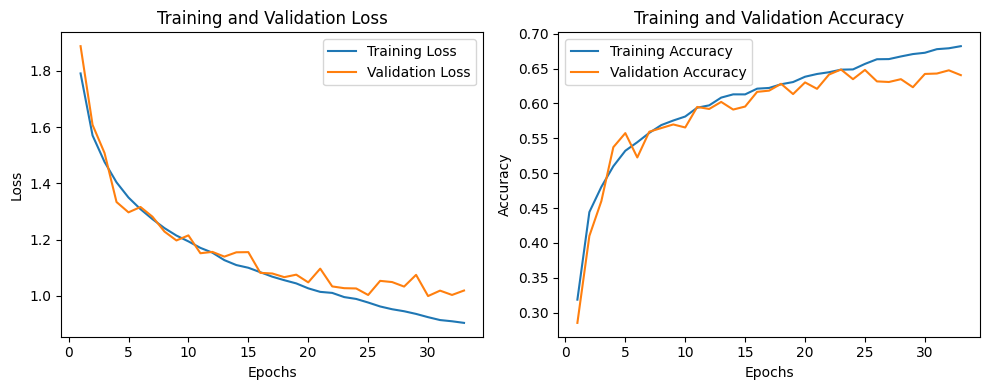

In [322]:
import matplotlib.pyplot as plt


epochs = []
for i in range(1,NUM_ECPOCH_RUNED+1):
  epochs.append(i)

# Plotting the Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs, train_loss_history, label='Training Loss')
plt.plot(epochs, valid_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting the Accuracy
plt.subplot(1, 2, 2)

plt.plot(epochs, train_acc_history, label='Training Accuracy')
plt.plot(epochs, valid_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [323]:
def test(test_loader, model, file_name='predict.csv'):
    with torch.no_grad():
        predict_result = []
        predict_name = []
        for img, name in test_loader:
            if use_gpu:
                img = img.to(device)
            output = model(img)
            predict = torch.argmax(output, dim=-1).tolist()
            predict_result += predict
            predict_name += name


    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for id, r in zip(predict_name, predict_result):
            writer.writerow([id, r])

In [324]:
del model
model = FaceExpressionNet()
model.load_state_dict(torch.load('model.pth'))
model = model.cuda()
test(test_loader, model)